## SAS HW3

#### 1. Какая доля 1 в выборке "accept"?  
**Ответ:** 2.14%

#### 2. Необходимо рассчитать для всех интервальных переменных следующее:
  - Доля пропущенных значений 
  - Медиана
  - Среднее
  - Среднеквадратическое отклонение
  - Есть ли аномальные значения, выбросы? 
  - Information Value  
**Ответ:**  
Accept

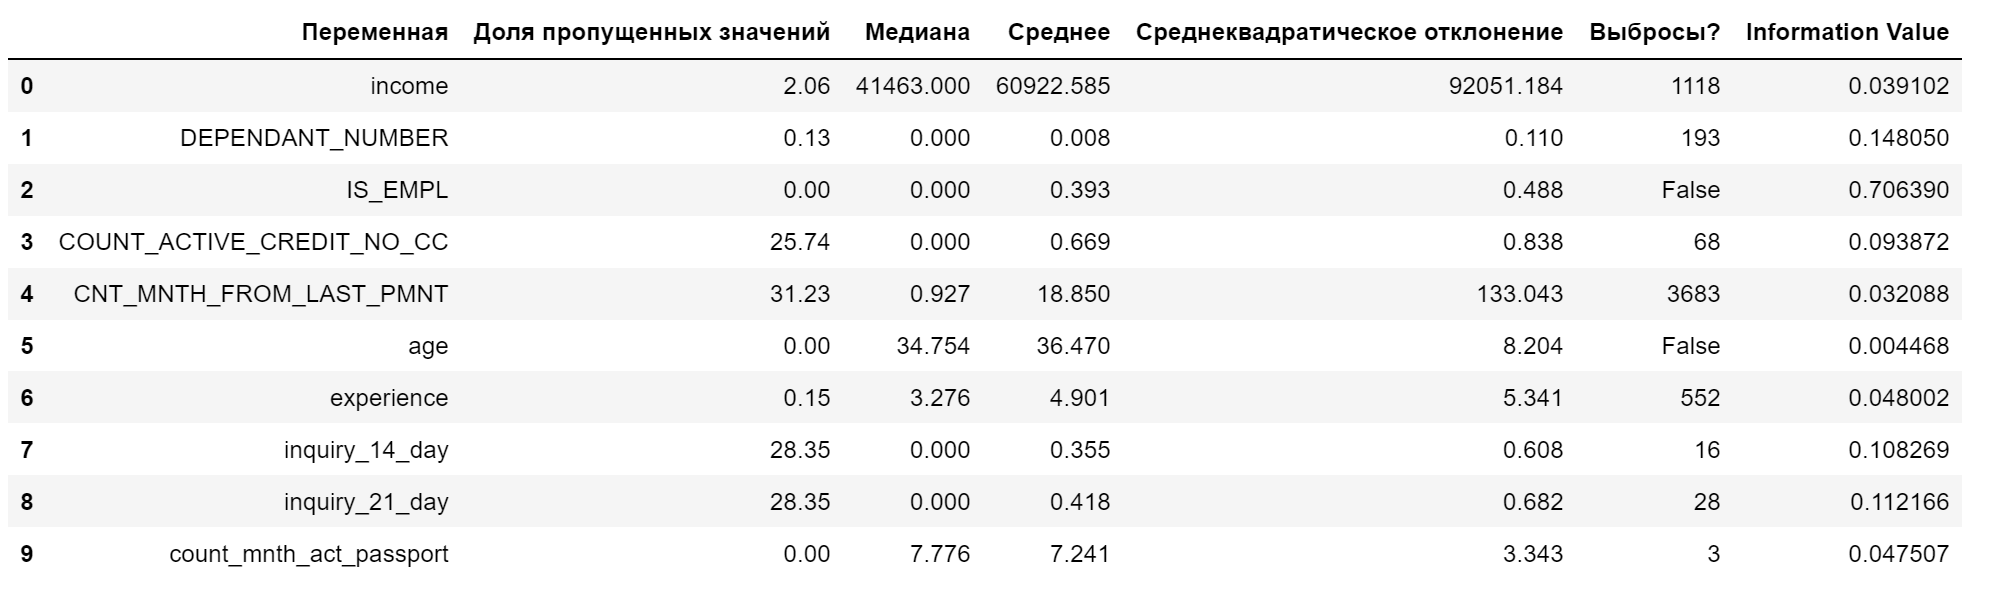

Reject

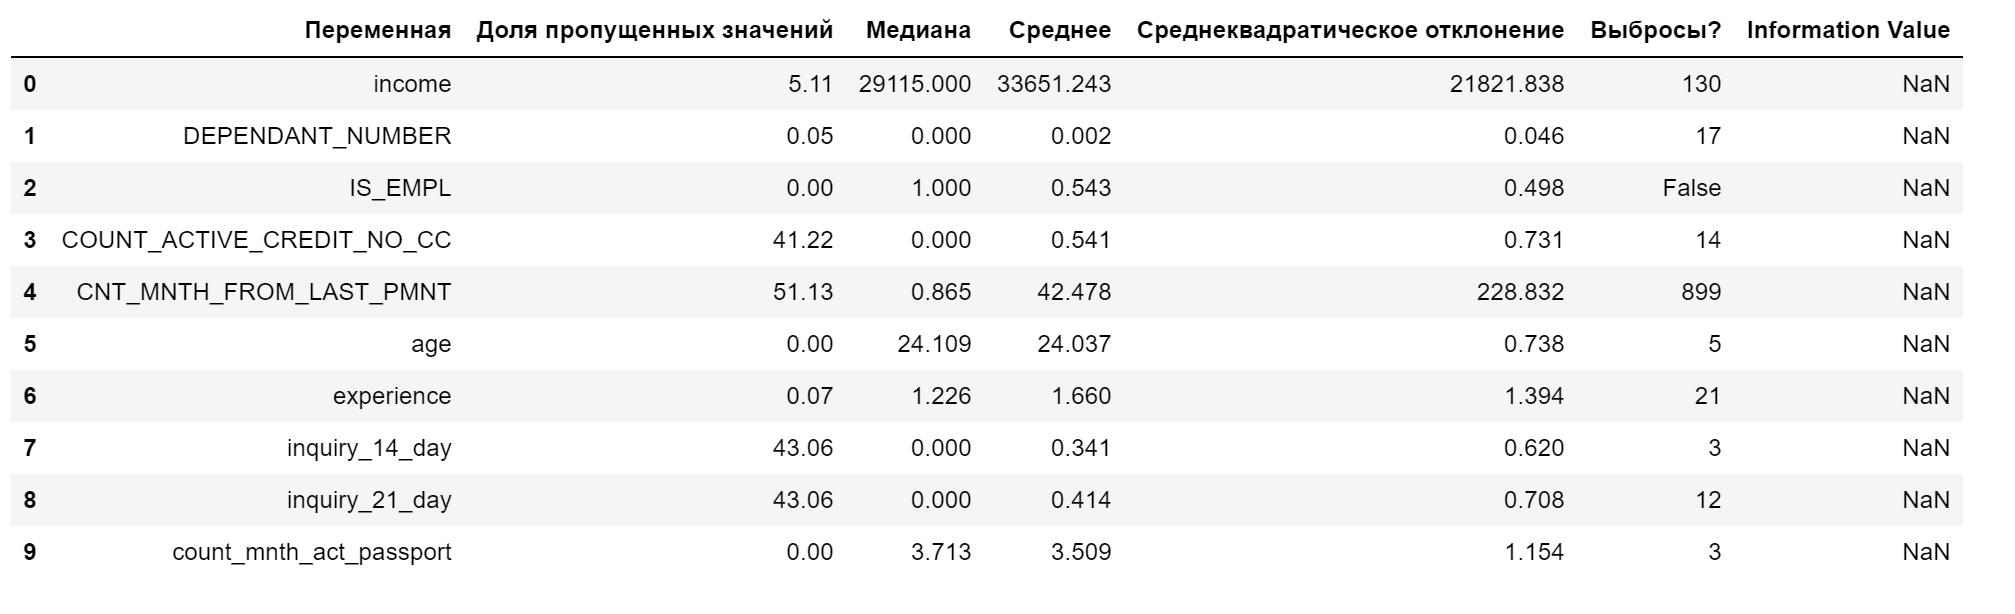

Я считал выбросами, те значения, которые выходили за интервал $[3 \cdot \text{quartile}(25\%); 3\cdot \text{quartile}(75\%)]$, а также отрицательные значения.

#### 3. Необходимо рассчитать для всех категориальных переменных следующее:
  - Мода
  - Доля пропущенных значений
  - Information Value
  - Есть ли выбросы, аномальные значений  
**Ответ:**  
Accept

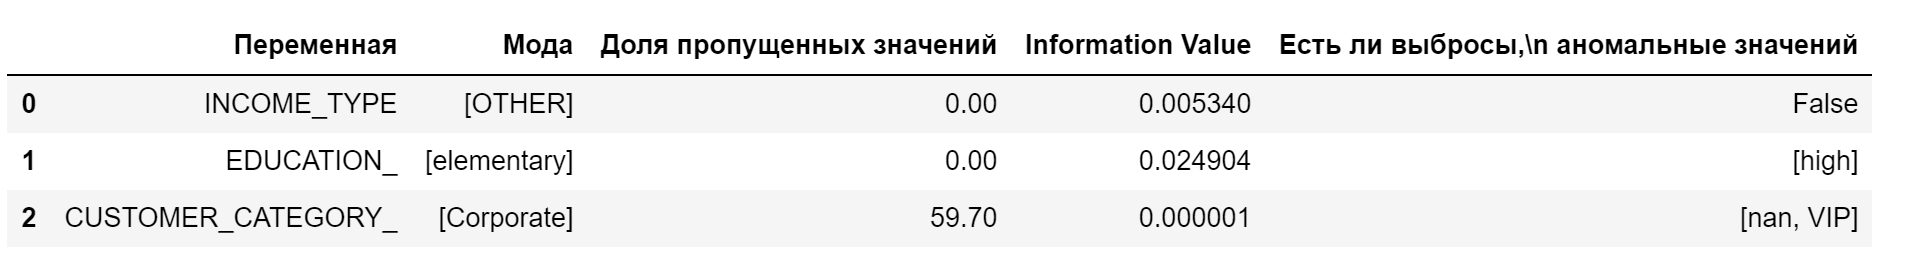

Reject

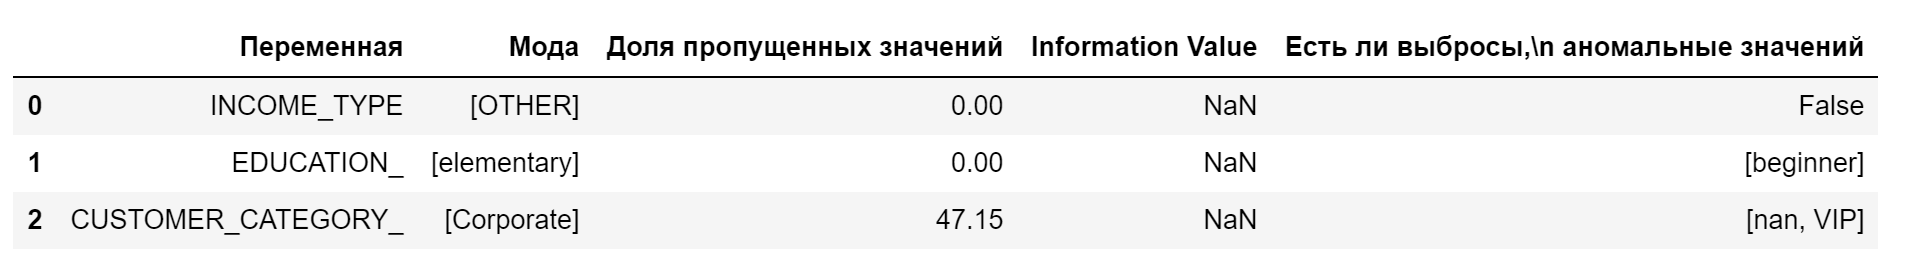

Я считал выбросами, те значения, чья доля в колонке была меньше 4%.

#### 4. Построить логистическую регрессию только на одобренных заявках с преобразованными переменными WoE. Какое значение GINI? F1 мера?
**Ответ:**  
См. построение лог регрессии ниже.

$Gini \approx 0.57$

$F1\text{-score} \approx 0.15$

#### 5. Провести анализ Reject Inference. Какая доля отказанных заявок? 
**Ответ:**  
См. ниже.  
Доля Единиц = 1.80% (зависит от порогового значения вероятности)

#### 6. Построить логистическую регрессию на всех заявках с преобразованными переменными WoE. Какое значение GINI, F1? Изменилась ли модель? 
**Ответ:**  
См. построение лог регрессии ниже.

$Gini \approx 0.61$

$F1\text{-score} \approx 0.17$

Наиболее заметны различия моделей на графиках precision, recall vs threshold. (Слева модель из пункта (4), справа из текущего пункта)

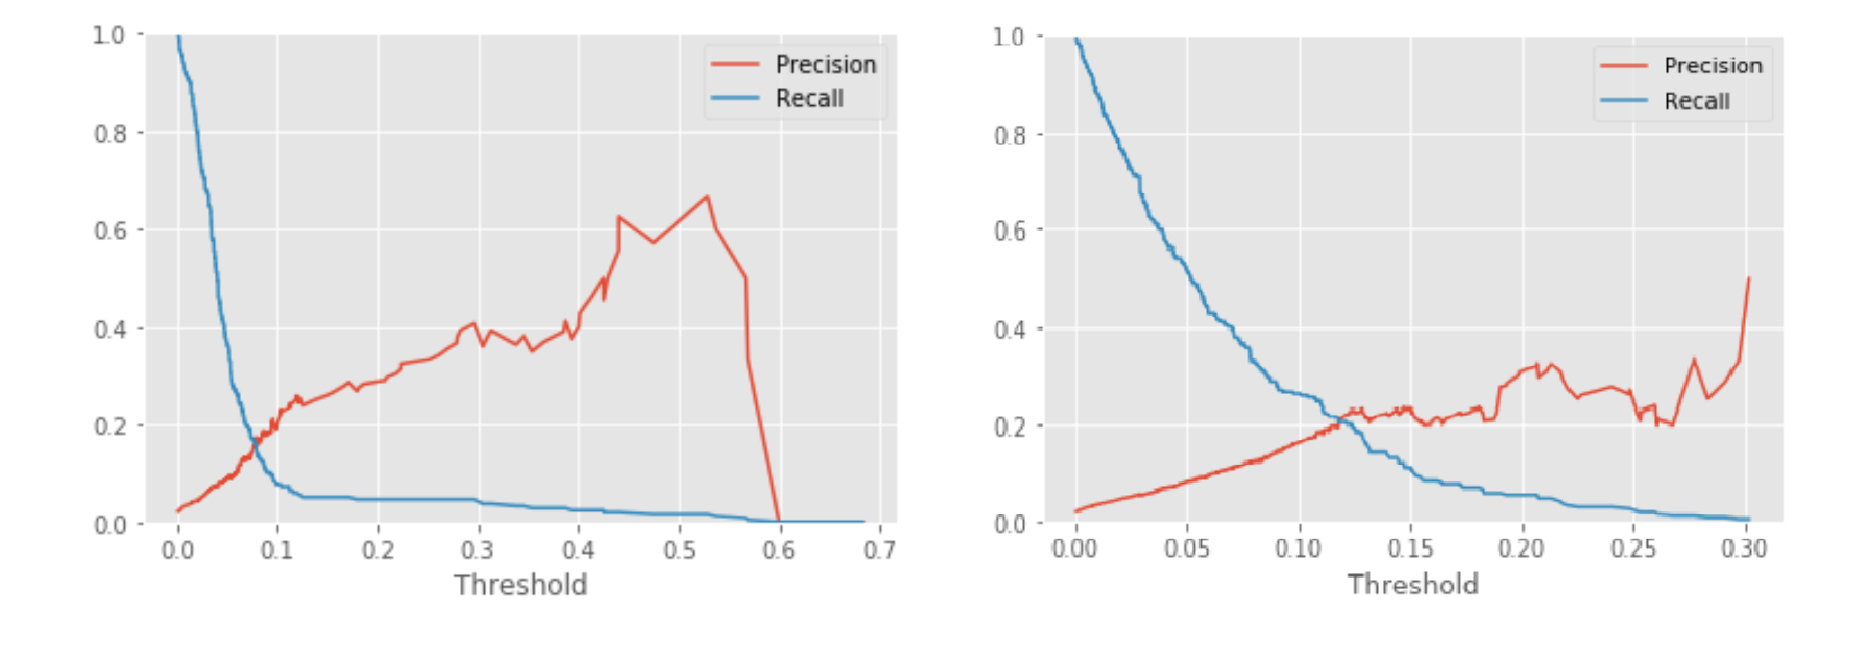

Мы можем заметить, что рост кривой recall намного меньше, чем падение precision. Однако, по формулировки нашей задачи, связанной с банковым скорингом, мы считаем recall более важным, так как лучше классифицировать некоторое малое количество клиентов как дефолтные даже если они таковыми не являются, а не наоборот, т.е. классифицировать плохого для банка клиента как хорошего. Поэтому, это некоторое незначительное улучшение.  
Также изменились показатели GINI, F1-score и AUC.

#### 7. Какую модель вы рекомендуете для внедрения в продуктивную среду? Дать развернутое пояснение.
**Ответ:**

Я рекомендую модель, построенную только на выборке accept с преобразованием WoE (т.е. первая модель). Такая модель совмещает преимущества stacking моделей (когда одна модель агрегирует предсказания другой модели). WoE преобразование включает в себя работу с целевой переменной, и поэтому, когда модель получает на вход WoE регрессоры, она с большой вероятностью предскажет правильный ответ нежели модель которая обучается на необработанных данных. Дополнительно, WoE преобразование решает проблему категориальных переменных, так как оно меняет категориальную колонку на числовую. Альтернативой является one-hot-encoding, однако создание многочисленного числа новых колонок ведет к значительному увеличению дисперсии в bias-variance tradeoff, в то время как WoE сохраняет кол-во предикторов.  

Также добавлю, что, WoE позволяет намного улучшить предсказания логистической регрессии. Это важно, так как более продвинутые с точки зрения точности модели намного хуже интерпретируются в сравнении с лог. регрессией, позволяющей оценить какое влияние оказывает каждый фактор на вероятность дефолта. К тому же обучается лог. регрессия намного быстрее, по сравнению с бустинговыми моделями.

Из минусов Logit+WoE(accept) можно отметить проблему потенциального переобучения. По этой причине следует аккуратно разделять выборки на подвыборки для обучения WoE и обучения самой модели.

Однако, для будущих предсказаний я бы не стал использовать модель, обученную на объединенной выборке accept + reject по некоторым причинам. Во-первых, это объедение нужно больше для “inference”(т.е. для вывода об отказанных заявках) нежели для будущего прогноза дефолта. Во-вторых, если первостепенной целью является предсказание дефолта, то более разумным будет обучаться на выборке с существующей целевой переменной, а не с её оценкой (как делает вторая модель, которая предсказывает таргет для выборки reject). Выборка принятых заявок сама по себе имеет достаточно количество наблюдений для того, чтобы модель, обученная на ней, была конкурентоспособна.


<hr>

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')

In [3]:
# загрузка файлов
acc = pd.read_csv("11_accept.csv").drop(columns=['UID'])
rej = pd.read_csv("11_reject.csv").drop(columns=['UID'])

In [4]:
acc

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport
0,0,2NDFL,elementary,NaN,56245.0,0.0,0,NaN,NaN,50.567123,2.131507,NaN,NaN,5.536986
1,0,2NDFL,advanced,NaN,12020.0,0.0,0,1.0,0.303786,36.437742,17.731507,0.0,0.0,9.123535
2,0,OTHER,advanced,Corporate,21611.0,0.0,1,NaN,NaN,33.333446,1.711528,NaN,NaN,7.972678
3,0,OTHER,elementary,VIP,146841.0,0.0,1,0.0,30.530914,36.531073,0.577648,0.0,0.0,7.737705
4,0,OTHER,elementary,Corporate,183461.0,0.0,1,0.0,1.186985,44.063014,0.512194,1.0,1.0,2.649315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32549,1,OTHER,advanced,NaN,20000.0,0.0,0,1.0,0.849776,25.885882,3.653005,0.0,0.0,4.855745
32550,1,2NDFL,elementary,NaN,57072.0,0.0,0,1.0,0.987545,52.517359,4.125683,1.0,1.0,5.188592
32551,1,OTHER,elementary,NaN,150000.0,0.0,0,NaN,NaN,27.732240,2.416057,NaN,NaN,7.674863
32552,1,OTHER,advanced,Corporate,40000.0,0.0,0,NaN,NaN,29.716581,5.363156,NaN,NaN,6.935759


In [5]:
rej

,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport
0,2NDFL,elementary,NaN,26106.0,0.0,0,0.0,1.666801,24.353193,3.284153,1.0,1.0,4.268261
1,2NDFL,elementary,NaN,30276.0,0.0,0,1.0,0.660461,23.534494,3.581069,0.0,0.0,1.411206
2,2NDFL,advanced,NaN,23147.0,0.0,0,0.0,4.342025,24.580021,0.645774,0.0,1.0,4.544405
3,2NDFL,advanced,NaN,33116.0,0.0,0,0.0,0.758714,23.284153,0.901130,0.0,0.0,3.183060
4,2NDFL,elementary,NaN,45972.0,0.0,0,NaN,NaN,24.528535,1.405247,NaN,NaN,3.581967
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688,2NDFL,advanced,NaN,24311.0,0.0,0,NaN,NaN,23.456284,1.188060,NaN,NaN,3.401639
10689,OTHER,elementary,NaN,21400.0,0.0,0,0.0,1.271550,24.040984,0.994303,0.0,0.0,2.739509
10690,OTHER,elementary,Corporate,22532.0,0.0,1,1.0,0.601299,24.442623,0.568531,1.0,1.0,4.377049
10691,OTHER,elementary,NaN,21750.0,0.0,0,NaN,NaN,23.218579,0.742039,NaN,NaN,3.002313


Создание функции, которая считает information value получая на вход датафрейм, имя нужной переменной и имя таргета.

In [6]:
def makeIV(table, variable, tar):
    make_df = []
    cols = ['Переменная', 'Значение', 'Goods', 'Bads']
    for uni in table[variable].unique(): # смотрим уникальные значения
        to_append = [variable, uni]
        indx1 = (table[variable] == uni) & (table[tar] == 0)
        indx2 = (table[variable] == uni) & (table[tar] == 1)
        to_append.append(table[indx1][variable].count())
        to_append.append(table[indx2][variable].count())
        make_df.append(to_append)
    iv_df = pd.DataFrame(make_df, columns=cols)
  
    sum_0 = table[table[tar] == 1].count()[variable]
    sum_1 = table.shape[0] - sum_0
    
    # считаем WOE по формуле
    iv_df['WOE'] = np.log((iv_df['Goods'] / sum_1) / (iv_df['Bads'] / sum_0))
    iv_df['WOE'] = iv_df['WOE'].replace([np.inf, -np.inf], [0, 0])
    
    # складываем WOE для получения IV
    iv_df['IV'] = iv_df['WOE'] * (iv_df['Goods']/ sum_1 - iv_df['Bads'] / sum_0)
    
    iv = sum(iv_df['IV'])
    di = dict(zip(iv_df['Значение'], iv_df['WOE']))
    df_new = table.replace({variable: di})
    
    return iv, iv_df, df_new[variable], di
    # Возвращает  information value, таблицу с преобразованиями,
    # преобразованную колнку WoE и словарь измененных значений.

#### Какая доля 1 в выборке "accept"?

In [7]:
share1 = 100 * acc.target.sum() / acc.target.count()
print("Доля Единиц = {:.2f}%".format(share1))

Доля Единиц = 2.14%


#### Необходимо рассчитать для всех интервальных переменных следующее:
- Доля пропущенных значений
- Медиана
- Среднее
- Среднеквадратическое отклонение
- Есть ли аномальные значения, выбросы?
- Information Value

In [8]:
table1 = pd.DataFrame(columns=[
    'Переменная', 'Доля пропущенных значений', 'Медиана', 'Среднее',
    'Среднеквадратическое отклонение', 'Выбросы?', 'Information Value'
])
table2 = pd.DataFrame(columns=[
    'Переменная', 'Доля пропущенных значений', 'Медиана', 'Среднее',
    'Среднеквадратическое отклонение', 'Выбросы?', 'Information Value'
])

In [9]:
table3 = pd.DataFrame(columns=[
    'Переменная', 'Мода', 'Доля пропущенных значений', 'Information Value',
    'Есть ли выбросы,\n аномальные значений'
])
table4 = pd.DataFrame(columns=[
    'Переменная', 'Мода', 'Доля пропущенных значений', 'Information Value',
    'Есть ли выбросы,\n аномальные значений'
])

Создаем функцию которая заполняет таблицу для интервальных переменных.

In [10]:
def fill_table_num(table, df):
    table = table.iloc[0:0]  #drop
    h = df.shape[0]
    for var in list(df):
        if var == 'target': continue
        if df[var].dtype != object: # смотрим если числовая
            
            skiped = 100 * df[var].isna().sum() / h # доля NaN
            skiped = "{:.2f}".format(skiped)

            med = "{:.3f}".format(np.median(df[var].dropna()))

            mean = "{:.3f}".format(df[var].mean())

            sd = "{:.3f}".format(df[var].std())
            
            # считаем кол-во выбросов
            q1, q3 = np.nanpercentile(df[var], [25, 75])
            lb = q1 - 3 * (q3 - q1)
            ub = q3 + 3 * (q3 - q1)
            # смотрим если есть значения за интервалом [3*q1; 3q3]
            # а также отрицательные
            outlier = any(df[var] > ub) | any(df[var] < lb) | (min(df[var]) < 0 )
            if outlier:
                outlier = sum(df[var] > ub) + sum(df[var] < lb) + sum(df[var] < 0)
            
            # делим на бины
            df_c = df.copy()
            quintiles = np.nanpercentile(df[var], [20, 30, 50])
            out = np.searchsorted(quintiles, df[var])
            new_name = var + "Q"
            df_c[new_name] = out
            
            # ищем Information Value
            IV = np.NaN
            if 'target' in list(df):
                iv = makeIV(df_c, new_name, 'target')
                IV = iv[0]
            # df[var] = iv[2]

            row = {
                'Переменная': var,
                'Доля пропущенных значений': skiped,
                'Медиана': med,
                'Среднее': mean,
                'Среднеквадратическое отклонение': sd,
                'Выбросы?': outlier,
                'Information Value': IV
            }

            table = table.append(row, ignore_index=True)
    return table

Создаем функцию которая заполняет таблицу для категориальных переменных.

In [11]:
def fill_table_cat(table, df):
    table = table.iloc[0:0]  #drop
    h = df.shape[0]
    for var in list(df):
        if df[var].dtype == object:
            mode = stats.mode(df[var])

            skiped = 100 * df[var].isna().sum() / h # считаем пропущенные
            skiped = "{:.2f}".format(skiped)
            
            # ищем Information Value
            IV = np.NaN
            if 'target' in list(df):
                iv = makeIV(df, var, 'target')
                IV = iv[0]
                if np.isnan(IV): IV = 0.000001
                
            # считаем кол-во выбросов
            outlier = []
            # считал выбросами, те значения,
            # чья доля в колонке была меньше 4%.
            for uni in df[var].unique():
                if sum(df[var] == uni) / h < 0.04:
                    outlier.append(uni)
            if len(outlier) == 0: outlier = False

            row = {
                'Переменная': var,
                'Мода': mode[0],
                'Доля пропущенных значений': skiped,
                'Information Value': IV,
                'Есть ли выбросы,\n аномальные значений': outlier
            }

            table = table.append(row, ignore_index=True)
    return table

Создаем функцию, которая делает полное заполнение таблицы преобразованными колонками WoE.

In [12]:
def makeWOE(df1):
    df = df1.copy()
    for var in list(df):
        if var == 'target': continue

        if df[var].dtype != object:

            df_c = df1.copy()
            # меняем NaN
            df_c[var] = df_c[var].replace(np.NaN, min(df_c[var]))
            
            # делим на бины
            quintiles = np.nanpercentile(df[var], [20, 30, 50])
            out = np.searchsorted(quintiles, df[var])
            new_name = var + "Q"
            df_c[new_name] = out
            
            # ищем Information Value
            IV = np.NaN
            if 'target' in list(df):
                iv = makeIV(df_c, new_name, 'target')
                df[var] = iv[2]

        else:
            if 'target' in list(df):
                iv = makeIV(df.replace(np.NaN, "MyNaN"), var, 'target')
                df[var] = iv[2]

    return df

Создаем функцию, которая делает полное заполнение  двух таблиц преобразованными колонками WoE основываясь на заполнении первой таблицы.

In [13]:
def makeWOEDouble(df0, df01):
    df = df0.copy()
    df1 = df01.copy()

    for var in list(df):
        if var == 'target': continue

        if df[var].dtype != object:

            df_c = df0.copy()

            df_c[var] = df_c[var].replace(np.NaN, min(df_c[var]))

            quintiles = np.nanpercentile(df[var], [20, 30, 50])
            out = np.searchsorted(quintiles, df[var])
            new_name = var + "Quintile"
            df_c[new_name] = out

            IV = np.NaN
            if 'target' in list(df):
                iv = makeIV(df_c, new_name, 'target')
                df[var] = iv[2]
                
                # Делаем WoE преобразовании колонки второй таблицы
                # на основе значений колонки из первой таблицы
                df_c = df01.copy()
                df_c[var] = df_c[var].replace(np.NaN, min(df_c[var]))
                quintiles = np.nanpercentile(df1[var], [20, 30, 50])
                out = np.searchsorted(quintiles, df1[var])
                df1[var] = out
                df1[var] = df1[var].map(iv[3])

        else:
            if 'target' in list(df):
                iv = makeIV(df.replace(np.NaN, "MyNaN"), var, 'target')
                df[var] = iv[2]
                
                # Делаем WoE преобразовании колонки второй таблицы
                # на основе значений колонки из первой таблицы
                df1[var] = df1[var].replace(np.NaN, "MyNaN").map(iv[3])

    return df, df1.fillna(0)

Заполняем таблицы.

In [14]:
table1 = fill_table_num(table1, acc)
table2 = fill_table_num(table2, rej)

In [15]:
table3 = fill_table_cat(table3, acc)
table4 = fill_table_cat(table4, rej)

In [16]:
table1

,Переменная,Доля пропущенных значений,Медиана,Среднее,Среднеквадратическое отклонение,Выбросы?,Information Value
0,income,2.06,41463.000,60922.585,92051.184,1118,0.039102
1,DEPENDANT_NUMBER,0.13,0.000,0.008,0.110,193,0.148050
2,IS_EMPL,0.00,0.000,0.393,0.488,False,0.706390
3,COUNT_ACTIVE_CREDIT_NO_CC,25.74,0.000,0.669,0.838,68,0.093872
4,CNT_MNTH_FROM_LAST_PMNT,31.23,0.927,18.850,133.043,3683,0.032088
5,age,0.00,34.754,36.470,8.204,False,0.004468
6,experience,0.15,3.276,4.901,5.341,552,0.048002
7,inquiry_14_day,28.35,0.000,0.355,0.608,16,0.108269
8,inquiry_21_day,28.35,0.000,0.418,0.682,28,0.112166
9,count_mnth_act_passport,0.00,7.776,7.241,3.343,3,0.047507


In [17]:
table2

,Переменная,Доля пропущенных значений,Медиана,Среднее,Среднеквадратическое отклонение,Выбросы?,Information Value
0,income,5.11,29115.000,33651.243,21821.838,130,NaN
1,DEPENDANT_NUMBER,0.05,0.000,0.002,0.046,17,NaN
2,IS_EMPL,0.00,1.000,0.543,0.498,False,NaN
3,COUNT_ACTIVE_CREDIT_NO_CC,41.22,0.000,0.541,0.731,14,NaN
4,CNT_MNTH_FROM_LAST_PMNT,51.13,0.865,42.478,228.832,899,NaN
5,age,0.00,24.109,24.037,0.738,5,NaN
6,experience,0.07,1.226,1.660,1.394,21,NaN
7,inquiry_14_day,43.06,0.000,0.341,0.620,3,NaN
8,inquiry_21_day,43.06,0.000,0.414,0.708,12,NaN
9,count_mnth_act_passport,0.00,3.713,3.509,1.154,3,NaN


#### 3. Необходимо рассчитать для всех категориальных переменных следующее:
  - Мода
  - Доля пропущенных значений
  - Information Value
  - Есть ли выбросы, аномальные значений  

In [18]:
table3

,Переменная,Мода,Доля пропущенных значений,Information Value,"Есть ли выбросы,\n аномальные значений"
0,INCOME_TYPE,[OTHER],0.00,0.005340,False
1,EDUCATION_,[elementary],0.00,0.024904,[high]
2,CUSTOMER_CATEGORY_,[Corporate],59.70,0.000001,"[nan, VIP]"


In [19]:
table4

,Переменная,Мода,Доля пропущенных значений,Information Value,"Есть ли выбросы,\n аномальные значений"
0,INCOME_TYPE,[OTHER],0.00,NaN,False
1,EDUCATION_,[elementary],0.00,NaN,[beginner]
2,CUSTOMER_CATEGORY_,[Corporate],47.15,NaN,"[nan, VIP]"


#### 4. Построить логистическую регрессию только на одобренных заявках с преобразованными переменными WoE. Какое значение GINI? F1 мера?

Чтобы избежать переобучение WoE, разделяем выборку accept на две части.

In [20]:
acc_fit, acc_other = train_test_split(acc, test_size=0.50, random_state=42)

Делаем преобразование WoE первой и второй частей выборки accept основываясь на первой части (то есть, не смотря на целевую переменную, заполняю колонки во второй части, также как заполнил в первой).

In [21]:
acc_woe1, acc_woe2 = makeWOEDouble(acc_fit, acc_other)

Делаем тоже самое, но в этот раз, вторая часть — это выборка reject. 

In [22]:
acc_woe1, rej_woe = makeWOEDouble(acc_fit, rej)

In [23]:
# Объедениям части accept
acc_woe = acc_woe1.append(acc_woe2, ignore_index=True)

In [24]:
pd.concat([acc_woe.isna().sum(), rej_woe.isna().sum()], axis=1)  #NaN counts

,0,1
target,0,NaN
INCOME_TYPE,0,0.0
EDUCATION_,0,0.0
CUSTOMER_CATEGORY_,0,0.0
income,0,0.0
DEPENDANT_NUMBER,0,0.0
IS_EMPL,0,0.0
COUNT_ACTIVE_CREDIT_NO_CC,0,0.0
CNT_MNTH_FROM_LAST_PMNT,0,0.0
age,0,0.0


In [25]:
TRSH = 0.075

Обучаем лог. регрессию на выборке accept.

In [26]:
y = acc_woe.target
X = acc_woe.drop(columns=['target'])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                test_size=0.33, random_state=42)

In [27]:
logit_acc = LogisticRegression().fit(X_train, y_train)

Предсказываем вероятность для тестовой выборки.

In [28]:
y_hat = logit_acc.predict_proba(X_test)[:, 1]

Считаем GINI.

In [29]:
gini = 2 * roc_auc_score(y_test, y_hat) - 1
print("GINI =", gini)

GINI = 0.5778434262851406


Считаем F1-score.

In [30]:
y_hat_bin = np.apply_along_axis(lambda x: (x >= TRSH) * 1, 0, y_hat)
print("F1 Score =", f1_score(y_test, y_hat_bin))

F1 Score = 0.15717092337917488


Смотрим результаты. 

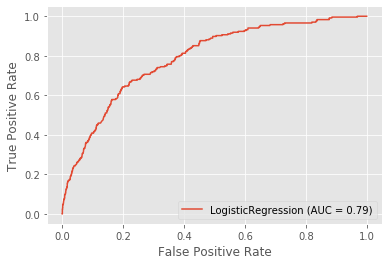

In [31]:
plot_roc_curve(logit_acc, X_test, y_test)
plt.show()

Значении AUC = 0.79 показывает, что модель достаточно достойная.

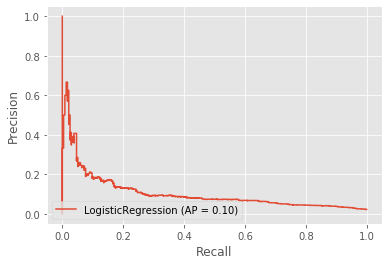

In [32]:
plot_precision_recall_curve(logit_acc, X_test, y_test)
plt.show()

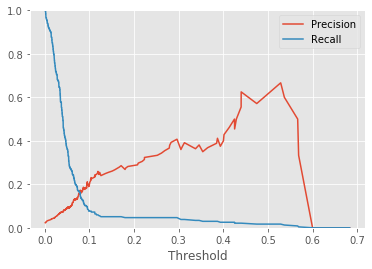

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper right")
plt.ylim([0, 1])
plt.show()

In [34]:
# Смотрим accuracy для разных пороговых значений вероятности.
ran = np.linspace(0, 0.1, 20)
for tr in ran:
    y_hat = logit_acc.predict_proba(X_test)[:, 1]
    clf = lambda x: (x >= tr) * 1
    y_hat_bin = np.apply_along_axis(clf, 0, y_hat)
    print("Treshold = {:.3f} \t Accuracy = {:.3f}".format(
        tr, np.mean(y_hat_bin == y_test)))

Treshold = 0.000 	 Accuracy = 0.022
Treshold = 0.005 	 Accuracy = 0.357
Treshold = 0.011 	 Accuracy = 0.458
Treshold = 0.016 	 Accuracy = 0.555
Treshold = 0.021 	 Accuracy = 0.633
Treshold = 0.026 	 Accuracy = 0.717
Treshold = 0.032 	 Accuracy = 0.778
Treshold = 0.037 	 Accuracy = 0.832
Treshold = 0.042 	 Accuracy = 0.871
Treshold = 0.047 	 Accuracy = 0.897
Treshold = 0.053 	 Accuracy = 0.914
Treshold = 0.058 	 Accuracy = 0.930
Treshold = 0.063 	 Accuracy = 0.943
Treshold = 0.068 	 Accuracy = 0.953
Treshold = 0.074 	 Accuracy = 0.958
Treshold = 0.079 	 Accuracy = 0.965
Treshold = 0.084 	 Accuracy = 0.967
Treshold = 0.089 	 Accuracy = 0.970
Treshold = 0.095 	 Accuracy = 0.972
Treshold = 0.100 	 Accuracy = 0.973


#### 5. Провести анализ Reject Inference. Какая доля отказанных заявок? 

Предсказываем таргет для выборки reject используя первую логистическую регрессию.

In [35]:
y_rej = logit_acc.predict_proba(rej_woe)[:, 1]

# Переводим вероятности в 0 и 1.
clf = lambda x: (x >= TRSH) * 1
y_rej_bin = np.apply_along_axis(clf, 0, y_rej)

# Добавляем колонку target в таблицу reject.
rej_woe_target = rej_woe.copy()
rej_woe_target['target'] = y_rej_bin

In [36]:
share2 = 100 * rej_woe_target.target.sum() / rej_woe_target.target.count()
print("Доля Единиц = {:.2f}%".format(share2))

Доля Единиц = 1.80%


#### 6. Построить логистическую регрессию на всех заявках с преобразованными переменными WoE. Какое значение GINI, F1? Изменилась ли модель? 

In [37]:
# Передвигаем target на первое место.
cols = list(rej_woe_target.columns)
cols = [cols[-1]] + cols[:-1]
rej_woe_target = rej_woe_target[cols]

Объединяем accept woe и reject woe.

In [38]:
df_join = acc_woe.append(rej_woe_target, ignore_index=True)

In [39]:
acc_woe.shape, rej_woe_target.shape, df_join.shape

((32554, 14), (10693, 14), (43247, 14))

In [40]:
df_join_fit, df_join_other = train_test_split(df_join, test_size=0.50, random_state=42)

In [41]:
df_join_woe1, df_join_woe2 = makeWOEDouble(df_join_fit, df_join_other)

Соединяем две части.

In [42]:
df_join_woe = df_join_woe1.append(df_join_woe2, ignore_index=True)

Строим регрессию на объединенной выборке.

In [43]:
y = df_join_woe.target
X = df_join_woe.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

In [44]:
logit_acc = LogisticRegression().fit(X_train, y_train)

Предсказываем вероятность для тестовой выборки.

In [45]:
y_hat = logit_acc.predict_proba(X_test)[:, 1]

Считаем GINI.

In [46]:
gini = 2 * roc_auc_score(y_test, y_hat) - 1
print("GINI =", gini)

GINI = 0.6123429621848739


Считаем F1-score.

In [47]:
y_hat_bin = np.apply_along_axis(lambda x: (x >= TRSH) * 1, 0, y_hat)

print("F1 Score =", f1_score(y_test, y_hat_bin))

F1 Score = 0.17694369973190346


Смотрим на результаты.

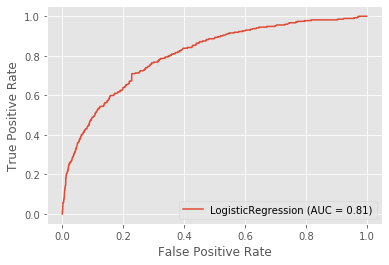

In [48]:
plot_roc_curve(logit_acc, X_test, y_test)
plt.show()

Как можем заметить, AUC увеличился, хотя не значительно.

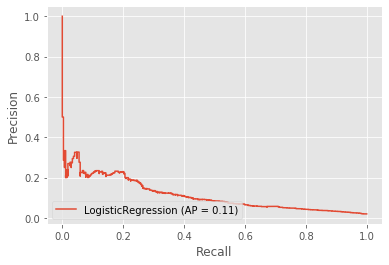

In [49]:
plot_precision_recall_curve(logit_acc, X_test, y_test)
plt.show()

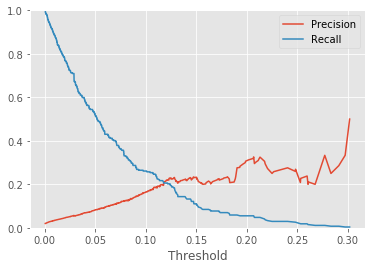

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper right")
plt.ylim([0, 1])
plt.show()

График кривой Recall стал убывать менее резко с ростом пороговой вероятности, в то время как график кривой Precision совсем поменял свою форму и стал более шумным.

#### 7. Какую модель вы рекомендуете для внедрения в продуктивную среду? Дать развернутое пояснение.
Ответ в начале файла.